In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, fixed
from scipy import stats

# Cofiguraciones
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,10)

# Lectura de datos

In [2]:
vehiculos = pd.read_csv("./Data/vehiculos_procesado.csv" , usecols=["consumo", "co2", "cilindros", "desplazamiento"])

litros_por_galon = 3.78541
vehiculos["consumo_litros_milla"] = litros_por_galon / vehiculos.consumo

In [3]:
vehiculos.shape

(35539, 5)

In [4]:
vehiculos.head()

,desplazamiento,cilindros,consumo,co2,consumo_litros_milla
0,2.5,4.0,17,522.764706,0.222671
1,4.2,6.0,13,683.615385,0.291185
2,2.5,4.0,16,555.437500,0.236588
3,4.2,6.0,13,683.615385,0.291185
4,3.8,6.0,16,555.437500,0.236588


# Regresión lineal - OLS (Ordinary Least Squares)  
  
    
      
El modelo de regresión lineal mediante OLS (ordinary least squares) tiene la forma:

$$ \hat{y} = \alpha + \beta_{1}*x_{1} + \beta_{2}*x_{2} + ... + \beta_{n}*x_{n} + \varepsilon$$

Donde $\hat{y}$ es la predicción que queremos hacer,

$\alpha$ es el término independiente,

$\beta_{n}$ es un vector de coeficientes
y $x_{n}$ son los valores de las variables del dataset.

El objetivo es obtener $\alpha$ y $\beta_{n}$  tales que error cuadrático (residuo) , definido como:

$$RSS = \varepsilon² = \sum\limits_{i=1}^n(y_{i} - (\alpha - \beta_{i}x_{i}))^2$$

sea el mínimo.

Para ello tenemos que resolver las siguientes equaciones

$$\hat{\alpha} = \bar{y} - \hat{\beta}*\bar{x}$$
$$\hat{\beta} = (X^TX)^{-1}X^Ty$$

# Definimos el porcentaje de entramiento

Hay que definir un porcentaje para los datos de entrenamiento, ya que los restantes se usarán para el test

In [5]:
pct_entrenamiento = 0.8

# Definimos los conjuntos de training y test

In [6]:
vehiculos_training = vehiculos.sample(frac=pct_entrenamiento)

vehiculos_test = vehiculos[~vehiculos.index.isin(vehiculos_training.index)]

In [7]:
print(vehiculos_training.shape)
print(vehiculos_test.shape)

(28431, 5)
(7108, 5)


# $$\hat{\beta}$$

A partir de aquí usamos el conjunto de training

In [12]:
variables_independientes = ["desplazamiento", "cilindros", "consumo_litros_milla"]
variable_dependiente = "co2"

X = vehiculos_training[variables_independientes].to_numpy()
y = vehiculos_training[variable_dependiente].to_numpy()
X_T = X.T

In [13]:
print("Tamaño de X: " + str(X.shape))
print("Tamaño de y: " + str(y.shape))
print("Tamaño de X_T: " + str(X_T.shape))
print("Matriz X:")
print(X)
print("Matriz y:")
print(y)
print("Matriz transpuesta X:")
print(X_T)

Tamaño de X: (28431, 3)
Tamaño de y: (28431,)
Tamaño de X_T: (3, 28431)
Matriz X:
[[2.5        4.         0.17206409]
 [2.4        4.         0.1892705 ]
 [3.5        6.         0.1892705 ]
 ...
 [2.8        4.         0.18025762]
 [1.9        4.         0.1514164 ]
 [3.5        5.         0.19923211]]
Matriz y:
[403.95454545 444.35       444.35       ... 423.19047619 355.48
 467.73684211]
Matriz transpuesta X:
[[2.5        2.4        3.5        ... 2.8        1.9        3.5       ]
 [4.         4.         6.         ... 4.         4.         5.        ]
 [0.17206409 0.1892705  0.1892705  ... 0.18025762 0.1514164  0.19923211]]


In [14]:
betas = np.linalg.inv(X_T @ X) @ X_T @ y

In [15]:
betas

array([ 3.92143977e+00, -6.30512893e-01,  2.30422507e+03])

# $$\hat{\alpha}$$

In [30]:
alfa = y.mean() - np.dot(betas,vehiculos_training[variables_independientes].mean())

In [31]:
alfa

0.3745166928993626

# Calcular predicción

In [37]:
def predecir(row):
    return alfa + np.dot(betas, row.values)

In [38]:
vehiculos_training["co2_pred"] = vehiculos_training[variables_independientes].apply(predecir, axis=1)
vehiculos_test["co2_pred"] = vehiculos_test[variables_independientes].apply(predecir, axis=1)

<ipython-input-38-2b4bf36eee6e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehiculos_test["co2_pred"] = vehiculos_test[variables_independientes].apply(predecir, axis=1)


In [39]:
model_formula = "y ~ {alfa:.3f} + {beta_1:.2f}*desplazamiento + {beta_2:.2f}*cilindros + {beta_3:.3f}*consumo_litros_milla".format(
    alfa=alfa, beta_1=betas[0], beta_2=betas[1], beta_3=betas[2])

model_formula

'y ~ 0.375 + 3.92*desplazamiento + -0.63*cilindros + 2304.225*consumo_litros_milla'

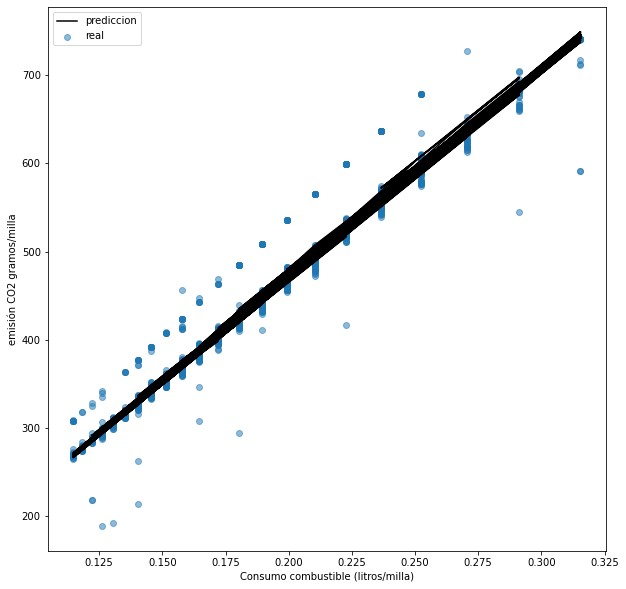

In [44]:
plt.scatter(vehiculos_test.consumo_litros_milla, vehiculos_test.co2, alpha=0.5, label="real")
#plt.text(0.1, 850, model_formula)
plt.plot(vehiculos_test.consumo_litros_milla, vehiculos_test.co2_pred, c="black", label="prediccion")
plt.xlabel("Consumo combustible (litros/milla)")
plt.ylabel("emisión CO2 gramos/milla")
plt.legend();

# Calculo del error

In [41]:
def error_cuadrático_medio(y, y_pred):
    return np.sum((y-y_pred)**2)/len(y)

In [42]:
error_training = error_cuadrático_medio(vehiculos_training.co2, vehiculos_training.co2_pred)
error_training

134.67234050998263

In [43]:
error_test = error_cuadrático_medio(vehiculos_test.co2, vehiculos_test.co2_pred)
error_test

117.86441112136936